By Anjali Singh (2020102004)

In [454]:
import os 
import cv2  
import numpy as np
import glob
import matplotlib.pyplot as plt

## Q1: Own Calibration 

### part-1

([], [])

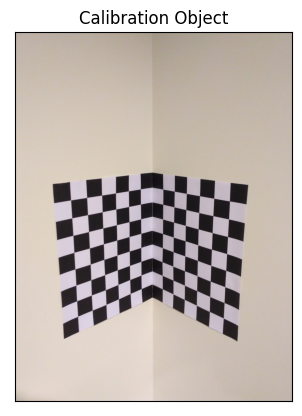

In [19]:
calib_img = cv2.imread('calib-object.jpg')
img_rgb = cv2.cvtColor(calib_img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Calibration Object")
# remove scales
plt.xticks([])
plt.yticks([])

In [3]:
# Identify/detect the chessboard internal corners 
# each square of the chessboard is 2cm x 2cm

def find_chessboard_corners(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    # detecting corners using harris corner detection
    hcd = cv2.cornerHarris(gray, 2, 3, 0.04)
    # dilate corner image to enhance corner points
    hcd = cv2.dilate(hcd, None)

    # threshold 
    threshold = 0.02 * hcd.max()
    corner_img = np.copy(img)
    for j in range(0, hcd.shape[0]):
        for i in range(0, hcd.shape[1]):
            if hcd[j,i] > threshold:
                cv2.circle(corner_img, (i, j), 1, (0, 255, 0), 20)
    plt.imshow(corner_img)



([], [])

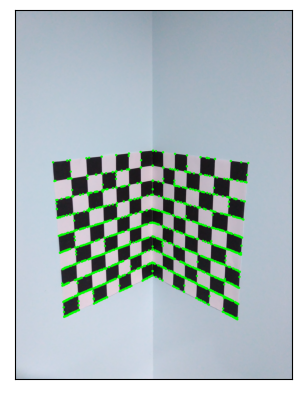

In [20]:
# img = cv2.imread('chessboard.jpg')
corner_img = find_chessboard_corners(calib_img)
# plt.imshow(corner_img)
plt.xticks([])
plt.yticks([])

### part-2

In [61]:

# Image coordinates (pixel locations) of corners in the chessboard
image_points = np.array([
                        [1543, 1594],
                        [1659, 1609],
                        [1793, 1627],
                        [1931, 1643],
                        [2080, 1663],
                        [2246, 1682],
                        [2421, 1705],
                        [2619, 1731],
                        [1411, 1605],
                        [1278, 1622],
                        [1134, 1638],
                        [972 , 1657],
                        [800 , 1676],
                        [616 , 1699],
                        [422 , 1719],
                        [1544, 1762],
                        [1544, 1927],
                        [1542, 2088],
                        [1540, 2243],
                        [1543, 2401],
                        [1543, 2552],
                        [1542, 2703],
                        [1541, 2850],
                        [1543, 3000]
])

# Corresponding world coordinates (in centimeters, assuming each square is 2cm x 2cm)
world_points = np.array([
                        [0,0,0],
                        [1,0,0],
                        [2,0,0],
                        [3,0,0],
                        [4,0,0],
                        [5,0,0],
                        [6,0,0],
                        [7,0,0],
                        [0,0,1],
                        [0,0,2],
                        [0,0,3],
                        [0,0,4],
                        [0,0,5],
                        [0,0,6],
                        [0,0,7],
                        [0,-1,0],
                        [0,-2,0],
                        [0,-3,0],
                        [0,-4,0],
                        [0,-5,0],
                        [0,-6,0],
                        [0,-7,0],
                        [0,-8,0],
                        [0,-9,0]
])

print(image_points.shape, world_points.shape)


(24, 2) (24, 3)


In [62]:
def projection_matrix(img_coordinates, world_coordinates, size, num_points=20):
    coords_3D=size*world_coordinates
    data_arr = np.zeros((2*num_points, 12))
    p = 0 
    for i in range(num_points):
        tmp_arr = np.zeros((2, 12))
        tmp_arr[0,0:3]= -coords_3D[i]
        tmp_arr[0,3] = -1
        tmp_arr[0,8:11] = img_coordinates[i, 0]*coords_3D[i]
        tmp_arr[0,11] = img_coordinates[i, 0]

        tmp_arr[1,4:7] = -coords_3D[i]
        tmp_arr[1,7] = -1
        tmp_arr[1,8:11] = img_coordinates[i,1]*coords_3D[i]
        tmp_arr[1,11] = img_coordinates[i,1]
        # print(tmp_arr)
        data_arr[p:p+2,:] = tmp_arr
        p += 2
    u, s, vh = np.linalg.svd(data_arr)
    v = vh.T
    # print(v[-1,:])
    P = (v[:, -1]).reshape((3, -1))
    return P

In [63]:
proj_matrix = projection_matrix(image_points, world_points, size = [28,28,28], num_points = world_points.shape[0])
print(proj_matrix)

[[ 9.80160837e-04 -2.22080792e-04 -2.80201459e-03  6.95448124e-01]
 [-6.72900864e-04 -2.94430989e-03 -6.08125186e-04  7.18563393e-01]
 [-5.70837725e-07 -1.44304569e-07 -5.21401246e-07  4.50885493e-04]]


In [66]:
def find_matrices(P):
    M = P[:, 0:3]
    # print(P.shape)
    p4 = P[:, 3]
    kkt = M@(M.T)
    k = np.zeros((3, 3))
    k[-1, -1] = 1
    k[0:2,-1] = kkt[0: 2, -1]
    k[1,1] = np.sqrt(kkt[1, 1]-k[1, -1]**2)
    k[0,1] = (kkt[0, 1]-k[1, -1]*k[0, -1])/(k[1, 1])
    k[0,0] = np.sqrt(kkt[0, 0]-k[0, 1]**2-k[0, 2]**2)
    R = np.linalg.inv(k)@M
    t = np.linalg.inv(k)@p4
    C = -np.linalg.inv(R)@t
    tmp=np.zeros((3,4))
    tmp[:,:3]=R
    tmp[:,-1]=-R@C
    P_tmp=k@tmp
    return k, R, C

In [67]:
# to find both the intrinsics and extrinsics 
K, R, c = find_matrices(proj_matrix)
print("K (Intrinsic Camera Matrix): \n", K)
print("R (Rotation Matrix): \n", R)
print("C (Translation Vector): \n", c)

K (Intrinsic Camera Matrix): 
 [[2.92531181e-03 5.51245593e-04 9.33508389e-10]
 [0.00000000e+00 3.08083959e-03 1.12607180e-09]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
R (Rotation Matrix): 
 [[ 3.76220070e-01  1.04172123e-01 -9.20655542e-01]
 [-2.18414768e-01 -9.55684257e-01 -1.97389435e-01]
 [-5.70837725e-07 -1.44304569e-07 -5.21401246e-07]]
C (Translation Vector): 
 [417.45495989  68.33994937 388.80744631]


### part 3

In [76]:
# Wireframe of the chessboard

def plot_wireframe_P(P, img, size = [28,28,28]):
    homo_size = np.ones((4, ))
    homo_size[:3] = size

    x1, y1, z1 = np.meshgrid(np.arange(0, 8), np.arange(0, -10, -1), 0)
    x2, y2, z2 = np.meshgrid(0,np.arange(0, -10, -1), np.arange(0, 8))
    x, y, z = np.arange(0, 8), np.arange(0, -10, -1), np.arange(0, 8)

    coords1 = np.stack((x1.flatten(),y1.flatten(),z1.flatten(),np.ones(x1.shape[0]*x1.shape[1]*x1.shape[2])),axis=0)
    coords2 = np.stack((x2.flatten(),y2.flatten(),z2.flatten(),np.ones(x2.shape[0]*x2.shape[1]*x2.shape[2])),axis=0)
    coords = np.concatenate((coords1,coords2),axis=1)
    coords = ((coords.T)*homo_size).T
    coords_uv = (P@coords)
    coords_uv = (coords_uv[:-1,:]/(coords_uv[-1,:]+1e-7)).T

    fig, axes=plt.subplots()
    im = axes.imshow(img)
    axes.scatter(coords_uv[:,0],coords_uv[:,1],color='r',s=10)

    e_coords=np.ones((4,2)).astype('int')
    e_coords[0,0]=x[0]*homo_size[0]
    e_coords[0,1]=x[-1]*homo_size[0]

    for i in range(coords1.shape[1]-1):
            e_coords1=coords1[...,i]*homo_size
            e_coords2=coords1[...,i+1]*homo_size
            # print(e_coords)
            uv1=P@e_coords1
            uv1=uv1//uv1[-1]
            if (i+1)%8!=0:
                uv2=P@e_coords2
                uv2=uv2//uv2[-1]
                axes.plot([uv1[0],uv2[0]],[uv1[1],uv2[1]],color='r')
            if i+8<coords1.shape[1]:
                e_coords3=coords1[...,i+8]*homo_size
                uv3=P@e_coords3
                uv3=uv3//uv3[-1]
                axes.plot([uv1[0],uv3[0]],[uv1[1],uv3[1]],color='r')
            # print(e_coords)
    for i in range(coords2.shape[1]-1):
        e_coords1=coords2[...,i]*homo_size
        e_coords2=coords2[...,i+1]*homo_size
        # print(e_coords)
        uv1=P@e_coords1
        uv1=uv1//uv1[-1]
        if (i+1)%8!=0:
            uv2=P@e_coords2
            uv2=uv2//uv2[-1]
            axes.plot([uv1[0],uv2[0]],[uv1[1],uv2[1]],color='r')
        if i+8<coords1.shape[1]:
            e_coords3=coords2[...,i+8]*homo_size
            uv3=P@e_coords3
            uv3=uv3//uv3[-1]
            # print(e_coords3)
            axes.plot([uv1[0],uv3[0]],[uv1[1],uv3[1]],color='r')
        # print(e_coords)
    plt.title("Wireframe")
    
    plt.show()
    
    # print(shape)

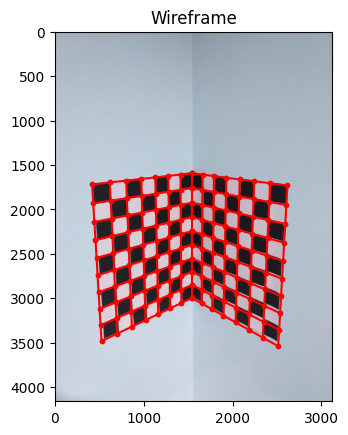

In [77]:
plot_wireframe_P(proj_matrix, calib_img, size = [28, 28, 28])
# print(calib_wireframe)

### part 4

In [70]:
# given the rotation matrix, compute the three rotation angles 
k, r, c = find_matrices(proj_matrix)

def rotation_angles(rotation_matrix):
    # formula to calculate rotation angles
    # sine (rotation about the vertical-axis)
    sine = np.sqrt(rotation_matrix[0, 0]**2 + rotation_matrix[1, 0]**2)

    singular = sine < 1e-6

    if not singular:
        x = np.arctan2(rotation_matrix[2, 1], rotation_matrix[2, 2])
        y = np.arctan2(-rotation_matrix[2, 0], sine)
        z = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
    else:
        x = np.arctan2(-rotation_matrix[1, 2], rotation_matrix[1, 1])
        y = np.arctan2(-rotation_matrix[2, 0], sine)
        z = 0

    return np.degrees(x), np.degrees(y), np.degrees(z)

In [471]:
x_angle, y_angle, z_angle = rotation_angles(r)
print("Rotation Angles (in degrees):-")
print("x_angle:", x_angle)
print("y_angle:", y_angle)
print("z_angle:", z_angle)

Rotation Angles (in degrees):-
x_angle: -164.5298810847637
y_angle: 7.518328736014669e-05
z_angle: -30.137331300089624


<b>Explain the values obtained in terms of pan, tilt, and roll. </b>

<b>pan </b> (or rotation about z-axis): This is indicating a significant left-right or panning motion. The negative sign suggests a clockwise rotation when looking along the positive Z-axis.
<br><b>tilt </b>(or rotation about y-axis): The small value suggests a negligible up-down or tilting motion. This extremely small value might be due to numerical precision or rounding during the computation done earlier. 
<br><b>roll </b>(or rotation about x-axis): The negative sign suggests a clockwise rotation when looking along the positive X-axis. 

## Q2: OpenCV Calibration 

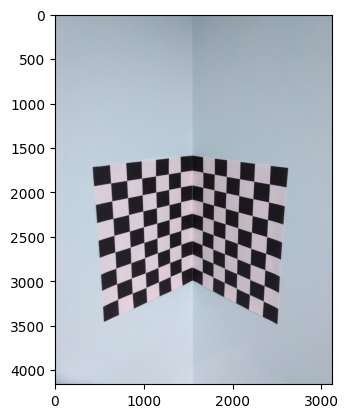

In [6]:
plt.imshow(calib_img)

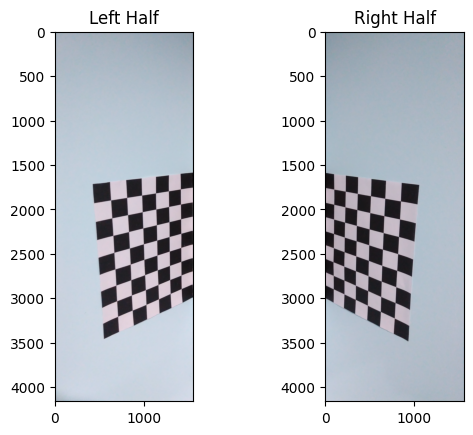

In [113]:
# divide the image above into two halves and display them side by side 

def split_image(img):
    half = img.shape[1]//2
    left = img[:, :half]
    right = img[:, half:]
    return left, right

left_img, right_img = split_image(calib_img)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(left_img)
axes[0].set_title("Left Half")
axes[1].imshow(right_img)
axes[1].set_title("Right Half")
plt.show()



### part 1

In [310]:
chessboard_param = (6, 8)
def calibrate_camera(image, chessboard_size, square_size):
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane

    # Prepare 3D object points
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:(chessboard_size[0]), 0:(chessboard_size[1])].T.reshape(-1, 2)
    objp = objp * square_size

    # img = cv2.imread(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print("gray:", gray.shape)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_param, flags=cv2.CALIB_CB_ADAPTIVE_THRESH
                                                + cv2.CALIB_CB_EXHAUSTIVE)

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

    # convert objpoints in list to array 
    objpoints = np.array(objpoints)
    # imgpoints = np.array(imgpoints)
    imgpoints = corners.reshape(1, -1, 2)
    
    print(objpoints.shape)
    print(imgpoints.shape)
    # Perform camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # Assume you have already obtained the camera matrix (mtx), rotation vectors (rvecs), and translation vectors (tvecs)
    R, _ = cv2.Rodrigues(rvecs[0])  # Convert the first rotation vector to a 3x3 rotation matrix
    t = tvecs[0]  # Get the first translation vector
    RT = np.hstack((R, t))  # Horizontally concatenate the rotation matrix and the translation vector
    P = np.dot(mtx, RT)  # Multiply the camera matrix with the rotation-translation matrix to obtain the projection matrix

    return mtx, dist, R, t

In [311]:
chessboard_size = left_img.shape
print(chessboard_size)
mtx_left, dist_left, R_left, t_left = calibrate_camera(left_img, (6, 8), 2)

# print("Projection Matrix:\n", proj_matrix_left)
print("Camera Matrix:\n", mtx_left)
print("Rotation Matrix:\n", R_left)
print("Translation Vector:\n", t_left)  

(4160, 1560, 3)
gray: (4160, 1560)
(1, 48, 3)
(1, 48, 2)
Camera Matrix:
 [[3.37123456e+03 0.00000000e+00 9.34860811e+02]
 [0.00000000e+00 3.16804538e+03 2.06125627e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation Matrix:
 [[ 0.78888355  0.03610699 -0.61348108]
 [-0.17280538  0.97102668 -0.16506209]
 [ 0.5897466   0.2362276   0.77226645]]
Translation Vector:
 [[-2.73849765]
 [-1.50778272]
 [30.33489644]]


Using the image and world coordinates that were hard coded in Q1

In [189]:
# Image coordinates (pixel locations) of corners in the chessboard
# Where z-axis = 0
image_points_1 = np.array([
                        [1543, 1594],
                        [1659, 1609],
                        [1793, 1627],
                        [1931, 1643],
                        [2080, 1663],
                        [2246, 1682],
                        [2421, 1705],
                        [2619, 1731],
                        # [1411, 1605],
                        # [1278, 1622],
                        # [1134, 1638],
                        # [972 , 1657],
                        # [800 , 1676],
                        # [616 , 1699],
                        # [422 , 1719],
                        [1544, 1762],
                        [1544, 1927],
                        [1542, 2088],
                        [1540, 2243],
                        [1543, 2401],
                        [1543, 2552],
                        [1542, 2703],
                        [1541, 2850],
                        [1543, 3000]
])

# Corresponding world coordinates (in centimeters, assuming each square is 2cm x 2cm)
world_points_1 = np.array([
                        [0,0,0],
                        [1,0,0],
                        [2,0,0],
                        [3,0,0],
                        [4,0,0],
                        [5,0,0],
                        [6,0,0],
                        [7,0,0],
                        # [0,0,1],
                        # [0,0,2],
                        # [0,0,3],
                        # [0,0,4],
                        # [0,0,5],
                        # [0,0,6],
                        # [0,0,7],
                        [0,-1,0],
                        [0,-2,0],
                        [0,-3,0],
                        [0,-4,0],
                        [0,-5,0],
                        [0,-6,0],
                        [0,-7,0],
                        [0,-8,0],
                        [0,-9,0]
])

print(image_points_1.shape, world_points_1.shape)


(17, 2) (17, 3)


In [250]:
gray_calib = cv2.cvtColor(calib_img, cv2.COLOR_BGR2GRAY)
print(world_points.shape)
print(image_points.shape)

img_points_copy = np.copy(image_points_1.reshape(1, -1, 2)).astype(np.float32)
world_points_copy = np.copy(world_points_1.reshape(1, -1, 3)).astype(np.float32)

print("Image Points Shape(z = 0):", img_points_copy.shape)
print("World Points Shape(z = 0):", world_points_copy.shape)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(world_points_copy, img_points_copy, gray_calib.shape[::-1], None, None)
R, _ = cv2.Rodrigues(rvecs[0])  # Convert the first rotation vector to a 3x3 rotation matrix
t = tvecs[0]  # Get the first translation vector
RT = np.hstack((R, t))  # Horizontally concatenate the rotation matrix and the translation vector
# P = np.dot(mtx, RT)

print("Camera Matrix (K, Intrinsic):\n", mtx)
print("Rotation Matrix (R):\n", R)
print("Translation Vector (C):\n", t)


(24, 3)
(24, 2)
Image Points Shape(z = 0): (1, 17, 2)
World Points Shape(z = 0): (1, 17, 3)
Camera Matrix (K, Intrinsic):
 [[6.89810684e+03 0.00000000e+00 1.44111621e+03]
 [0.00000000e+00 4.14542084e+03 2.10920866e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation Matrix (R):
 [[ 0.39994096 -0.00313094 -0.91653556]
 [ 0.19651104 -0.9764462   0.08908548]
 [-0.89522659 -0.21573829 -0.38990557]]
Translation Vector (C):
 [[ 0.36542323]
 [-3.06542607]
 [24.95752598]]


From Q1, the following were the parameters: - <br>
K (Intrinsic Camera Matrix):  <br>
 [[2.92531181e-03 5.51245593e-04 9.33508389e-10] <br>
 [0.00000000e+00 3.08083959e-03 1.12607180e-09] <br>
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] <br>
 <br>
R (Rotation Matrix): <br>
 [[ 3.76220070e-01  1.04172123e-01 -9.20655542e-01] <br>
 [-2.18414768e-01 -9.55684257e-01 -1.97389435e-01] <br>
 [-5.70837725e-07 -1.44304569e-07 -5.21401246e-07]] <br>
 <br>
C (Translation Vector): <br>
 [417.45495989  68.33994937 388.80744631] <br>

In [251]:
# Calculate projection matrix using the camera matrix, rotation matrix, and translation vector
proj_matrix_new = np.dot(mtx, RT)

print("Projection Matrix:-\n", proj_matrix_new)

Projection Matrix:-
 [[ 1.46870993e+03 -3.32501492e+02 -6.88425942e+03  3.84874237e+04]
 [-1.07359870e+03 -4.50281750e+03 -4.53095407e+02  3.99331488e+04]
 [-8.95226586e-01 -2.15738287e-01 -3.89905568e-01  2.49575260e+01]]


In [472]:
wireframe_points = np.array([
    [0, 0, 0, 1], 
    [7, 0, 0, 1], 
    [7, -9, 0, 1],
    [0, -9, 0, 1],
    [0, -9, 7, 1],
    [0, 0, 7, 1],
])

In [473]:
proj_matrix_new

array([[ 1.46870993e+03, -3.32501492e+02, -6.88425942e+03,
         3.84874237e+04],
       [-1.07359870e+03, -4.50281750e+03, -4.53095407e+02,
         3.99331488e+04],
       [-8.95226586e-01, -2.15738287e-01, -3.89905568e-01,
         2.49575260e+01]])

In [474]:
wireframe_img_points = (proj_matrix_new@wireframe_points.T).T

In [475]:
wireframe_img_2d = np.int32(wireframe_img_points[:,:2]/(wireframe_img_points[:,None, 2])).reshape(-1, 1, 2)

In [476]:

wireframe_img = np.copy(calib_img)
    
wireframe_img = cv2.polylines(wireframe_img, [wireframe_img_2d], True, (0, 8, 255), 8)
cv2.imwrite("wireframe_new.jpg", wireframe_img)

True

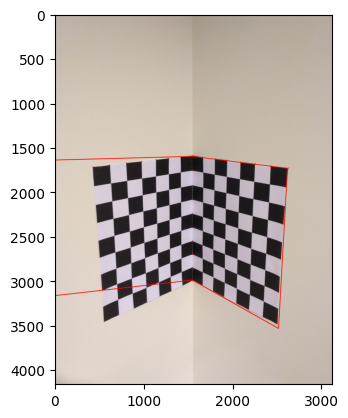

In [477]:
plt.imshow(cv2.cvtColor(wireframe_img, cv2.COLOR_BGR2RGB))

In [481]:
# Image coordinates (pixel locations) of corners in the chessboard
# Where z-axis = 0
image_points_2 = np.array([
                        [1543, 1594],
                        [1659, 1609],
                        [1793, 1627],
                        [1931, 1643],
                        [2080, 1663],
                        [2246, 1682],
                        [2421, 1705],
                        [2619, 1731],
                        [1411, 1605],
                        [1278, 1622],
                        [1134, 1638],
                        [972 , 1657],
                        [800 , 1676],
                        [616 , 1699],
                        [422 , 1719],
                        [1544, 1762],
                        [1544, 1927],
                        [1542, 2088],
                        [1540, 2243],
                        [1543, 2401],
                        [1543, 2552],
                        [1542, 2703],
                        [1541, 2850],
                        [1543, 3000]
])

# Corresponding world coordinates (in centimeters, assuming each square is 2cm x 2cm)
world_points_2 = np.array([
                        [0,0,0],
                        [1,0,0],
                        [2,0,0],
                        [3,0,0],
                        [4,0,0],
                        [5,0,0],
                        [6,0,0],
                        [7,0,0],
                        [0,0,1],
                        [0,0,2],
                        [0,0,3],
                        [0,0,4],
                        [0,0,5],
                        [0,0,6],
                        [0,0,7],
                        [0,-1,0],
                        [0,-2,0],
                        [0,-3,0],
                        [0,-4,0],
                        [0,-5,0],
                        [0,-6,0],
                        [0,-7,0],
                        [0,-8,0],
                        [0,-9,0]
])

print(image_points_1.shape, world_points_1.shape)


(17, 2) (17, 3)


In [485]:
# gray_calib = cv2.cvtColor(calib_img, cv2.COLOR_BGR2GRAY)
# print(world_points.shape)
# print(image_points.shape)

img_points_copy = np.copy(image_points_2.reshape(1, -1, 2)).astype(np.float32)
world_points_copy = np.copy(world_points_2.reshape(1, -1, 3)).astype(np.float32)

print("Image Points Shape(z = 0):", img_points_copy.shape)
print("World Points Shape(z = 0):", world_points_copy.shape)


flags = cv2.CALIB_USE_INTRINSIC_GUESS
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(world_points_copy, img_points_copy, gray_calib.shape[::-1], mtx, None, flags=flags)
R, _ = cv2.Rodrigues(rvecs[0])  # Convert the first rotation vector to a 3x3 rotation matrix
t = tvecs[0]  # Get the first translation vector
RT = np.hstack((R, t))  # Horizontally concatenate the rotation matrix and the translation vector
# P = np.dot(mtx, RT)

print("Camera Matrix (K, Intrinsic):\n", mtx)
print("Rotation Matrix (R):\n", R)
print("Translation Vector (C):\n", t)


Image Points Shape(z = 0): (1, 24, 2)
World Points Shape(z = 0): (1, 24, 3)
Camera Matrix (K, Intrinsic):
 [[3.58596000e+03 0.00000000e+00 1.63691616e+03]
 [0.00000000e+00 3.60648367e+03 2.07466373e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation Matrix (R):
 [[ 0.70465108  0.00627343 -0.70952625]
 [ 0.18363837 -0.96750338  0.1738222 ]
 [-0.68537858 -0.25278024 -0.68290435]]
Translation Vector (C):
 [[-0.56246904]
 [-2.82531788]
 [21.18236148]]


In [491]:
proj_matrix_new_total = np.dot(mtx, RT)
proj_matrix_new_total

array([[ 1.40494333e+03, -3.91283799e+02, -3.66218990e+03,
         3.26567583e+04],
       [-7.59641307e+02, -4.01371915e+03, -7.89909964e+02,
         3.37568143e+04],
       [-6.85378581e-01, -2.52780242e-01, -6.82904349e-01,
         2.11823615e+01]])

In [492]:
wireframe_img_points = (proj_matrix_new_total@wireframe_points.T).T
wireframe_img_2d = np.int32(wireframe_img_points[:,:2]/(wireframe_img_points[:,None, 2])).reshape(-1, 1, 2)
wireframe_img = np.copy(calib_img)
    
wireframe_img = cv2.polylines(wireframe_img, [wireframe_img_2d], True, (0, 8, 255), 8)
cv2.imwrite("wireframe_new.jpg", wireframe_img)

True

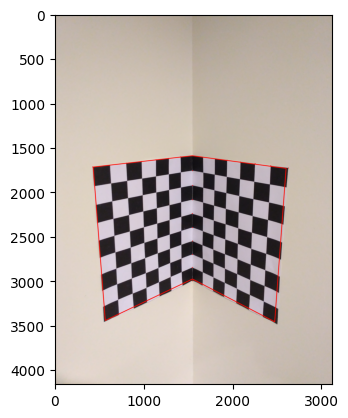

In [493]:
plt.imshow(cv2.cvtColor(wireframe_img, cv2.COLOR_BGR2RGB))

From Q1, the projection matrix was: - <br>
[[ 9.80160837e-04 -2.22080792e-04 -2.80201459e-03  6.95448124e-01] <br>
 [-6.72900864e-04 -2.94430989e-03 -6.08125186e-04  7.18563393e-01] <br>
 [-5.70837725e-07 -1.44304569e-07 -5.21401246e-07  4.50885493e-04]] <br>

<b>Observations: </b>
The projection matrix with the new parameters have scaled down by a factor of approximately 1.4 than the previous projection matrix. <br>

The consistency of the wireframe is maintained here as well. 

### part 2

([], [])

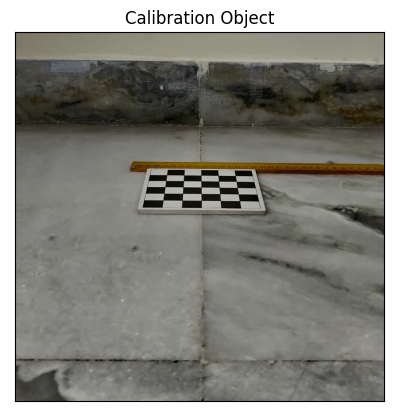

In [258]:
assign_img = cv2.imread('assign1.jpg')
img_rgb = cv2.cvtColor(assign_img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Calibration Object")
# remove scales
plt.xticks([])
plt.yticks([])

In [312]:
chessboard_param = (5, 5)
def calibrate_camera_assign(image, chessboard_size, square_size):
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane

    # Prepare 3D object points
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[1:(chessboard_size[0]+1), 1:(chessboard_size[1]+1)].T.reshape(-1, 2)
    objp = objp * square_size

    # img = cv2.imread(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print("gray:", gray.shape)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_param, flags=cv2.CALIB_CB_ADAPTIVE_THRESH
                                                + cv2.CALIB_CB_EXHAUSTIVE)

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

    # convert objpoints in list to array 
    objpoints = np.array(objpoints)
    # imgpoints = np.array(imgpoints)
    imgpoints = corners.reshape(1, -1, 2)
    
    print(objpoints.shape)
    print(imgpoints.shape)
    # Perform camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # Assume you have already obtained the camera matrix (mtx), rotation vectors (rvecs), and translation vectors (tvecs)
    R, _ = cv2.Rodrigues(rvecs[0])  # Convert the first rotation vector to a 3x3 rotation matrix
    t = tvecs[0]  # Get the first translation vector
    RT = np.hstack((R, t))  # Horizontally concatenate the rotation matrix and the translation vector
    P = np.dot(mtx, RT)  # Multiply the camera matrix with the rotation-translation matrix to obtain the projection matrix

    return mtx, dist, R, t

In [313]:
gray_assign = cv2.cvtColor(assign_img, cv2.COLOR_BGR2GRAY)


mtx_assign, dist_assign, R_assign, t_assign = calibrate_camera_assign(assign_img, (5, 5), 2)

print("Camera Matrix, assign1\n", mtx_assign)
print("Rotation Matrix, assign1\n", R_assign)
print("Translation Matrix, assign1\n", t_assign)

gray: (2112, 2112)
(1, 25, 3)
(1, 25, 2)
Camera Matrix, assign1
 [[1.61628849e+03 0.00000000e+00 1.04241010e+03]
 [0.00000000e+00 6.74414517e+02 1.06031119e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation Matrix, assign1
 [[ 9.99146581e-01  5.62666358e-04 -4.13012507e-02]
 [ 1.52976810e-02  9.23761990e-01  3.82661425e-01]
 [ 3.83678363e-02 -3.82966668e-01  9.22965027e-01]]
Translation Matrix, assign1
 [[ -5.57052662]
 [-13.31817827]
 [ 33.0745566 ]]


In [314]:
RT_assign = np.hstack((R_assign, t_assign))
proj_matrix_assign = np.dot(mtx_assign, RT_assign)
print("RT\n", RT_assign)
print("Projection Matrix:-\n", proj_matrix_assign)

RT
 [[ 9.99146581e-01  5.62666358e-04 -4.13012507e-02 -5.57052662e+00]
 [ 1.52976810e-02  9.23761990e-01  3.82661425e-01 -1.33181783e+01]
 [ 3.83678363e-02 -3.82966668e-01  9.22965027e-01  3.30745566e+01]]
Projection Matrix:-
 [[ 1.65490414e+03 -3.98298892e+02  8.95353331e+02  2.54736738e+04]
 [ 5.09988243e+01  2.16934653e+02  1.23670257e+03  2.60873498e+04]
 [ 3.83678363e-02 -3.82966668e-01  9.22965027e-01  3.30745566e+01]]


In [320]:
wireframe_points_assign = np.array([
    [0, 0, 0, 1], 
    [12, 0, 0, 1], 
    [12, 12, 0, 1],
    [0, 12, 0, 1],
])

In [321]:
wireframe_img_points_assign = (proj_matrix_assign@wireframe_points_assign.T).T

In [322]:
wireframe_img_assign_2d = np.int32(wireframe_img_points_assign[:,:2]/(wireframe_img_points_assign[:,None, 2])).reshape(-1, 1, 2)

In [323]:
wireframe_img_assign = np.copy(assign_img)

wireframe_img_assign = cv2.polylines(wireframe_img_assign, [wireframe_img_assign_2d], True, (0, 8, 255), 8)
cv2.imwrite("wireframe_new_assign.jpg", wireframe_img_assign)

True

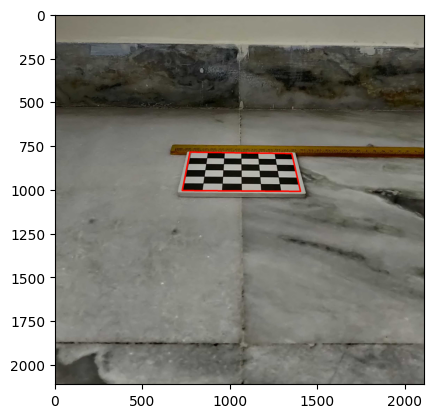

In [324]:
plt.imshow(cv2.cvtColor(wireframe_img_assign, cv2.COLOR_BGR2RGB))

<b>Does the wireframe overlay show significant distortions? Comment. What can we say about the computed projection matrix when trying to do calibration based on world coordinate points that are co-planar? (Hint: we looked at co-planar points in two-view geometry). </b> <br>

No, the wireframe overlay doesn't show any significant distortions. It works perfectly with consistency. <br>
It can be difficult to determine the camera parameters when trying to do calibration based on world coordinate points that are co-planer based on two-view geometry as well. It makes the matrix rank-deficient, i.e., not all parameters can be determined uniquely. 

### part 3

<b> What is the image of the world origin, given the calibration matrix? Does this result agree with your observations? </b><br>
<br>
The image of the world origin (0, 0, 0) in the calibrated camera is given by the multiplication of the calibration matrix by the homogeneous coordinates of the world origin. <br>

Yes, the result agrees with the observation.  

In [497]:
I = proj_matrix_assign@wireframe_points_assign.T
print("Image of the world coordinates:\n", I)

Image of the world coordinates:
 [[2.54736738e+04 4.53325235e+04 4.05529368e+04 2.06940871e+04]
 [2.60873498e+04 2.66993357e+04 2.93025515e+04 2.86905656e+04]
 [3.30745566e+01 3.35349706e+01 2.89393706e+01 2.84789566e+01]]


## Q3: Moving the Chessboard

### part 1

In [400]:
wireframe_points_assign_moved = np.array([
    [10, 0, 0, 1], 
    [22, 0, 0, 1], 
    [22, 12, 0, 1],
    [10, 12, 0, 1],
])

In [401]:
wireframe_img_points_assign_moved = (proj_matrix_assign@wireframe_points_assign_moved.T).T

In [402]:
wireframe_img_assign_2d_moved = np.int32(wireframe_img_points_assign_moved[:,:2]/(wireframe_img_points_assign_moved[:,None, 2])).reshape(-1, 1, 2)

In [403]:
wireframe_img_assign_moved = np.copy(assign_img)
    
wireframe_img_assign_moved = cv2.polylines(wireframe_img_assign_moved, [wireframe_img_assign_2d_moved], True, (0, 8, 255), 8)
cv2.imwrite("wireframe_new_assign.jpg", wireframe_img_assign_moved)

True

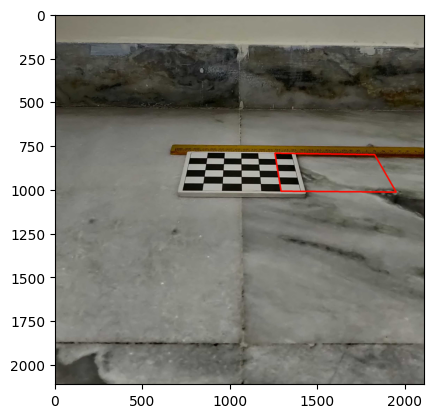

In [404]:
plt.imshow(cv2.cvtColor(wireframe_img_assign_moved, cv2.COLOR_BGR2RGB))

<b> Does the wireframe look consistent with what you expect? </b>

Yes, the wireframe looks consistent and has gotten shifted by 10 cms according to the virtual chessboard. 

### part 2

 Now, think of how you would move the actual pixels or pattern of the chessboard? Overlay the chessboard pattern within the predicted wireframe. Is the overlay consistent with what you expect?


In [463]:
points_to_copy = np.linspace(0, 12, 1000)
xx, yy = np.meshgrid(points_to_copy, points_to_copy)


In [464]:
points = np.dstack([xx, yy]).reshape(-1, 2)
points = np.column_stack([
    points, 
    np.zeros(points.shape[0], np.int32),
    np.ones(points.shape[0], np.int32),
])
points = np.float32(points)

In [465]:
initial_coordinates = (proj_matrix_assign @ points.T).T

In [466]:
initial_coordinates = np.int32(
    initial_coordinates[:, :2] / initial_coordinates[:, None, 2]
)

In [467]:
new_coordinates = (proj_matrix_assign @ (points + np.array([12, 0, 0, 0])).T).T

In [468]:
new_coordinates = np.int32(
    new_coordinates[:, :2] / new_coordinates[:, None, 2]
)

In [469]:
shifted_img = np.copy(assign_img)

shifted_img[new_coordinates[:, 1], new_coordinates[:, 0], :] = shifted_img[initial_coordinates[:, 1], initial_coordinates[:, 0], :]
cv2.imwrite("shifted_assign1.jpg", shifted_img)

True

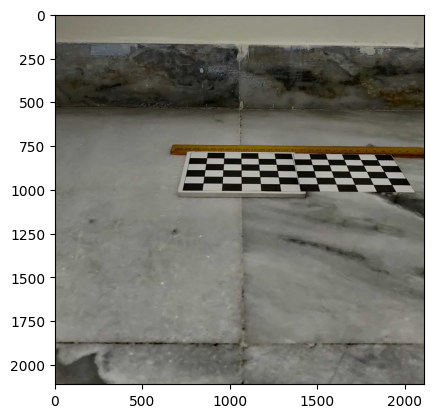

In [470]:
plt.imshow(cv2.cvtColor(shifted_img, cv2.COLOR_BGR2RGB))

<b> Is the overlay consistent with what you expect? </b>

Yes, the overlay is consistent with the shifted wireframe created in the previous part. 

#### Challenges and Learnings
<br>
One of the challenges faced were taking care of the dimensions of the matrices. It needed to be reshaped for every other case otherwise it was throwing errors. <br><br>
Camera calibration and wireframing were the two major things that I learned using openCV. <br><br>
Even though the functions created (non-openCV functions made) gave better results than using the openCV functions. 